In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
GSS = pd.read_csv(r"C:\Users\wjian\Desktop\GSS_Project\Data Files\GSS.csv")
pd.set_option('display.max_columns', None)
print(GSS.shape)
GSS.head(2)

# Selecting relevant variables -> for future codes, make selection of variables more versatile 

relevant_columns = ['year', 'id_', 'ballot', # Identifiers
    'happy', 'satjob', 'life', 'health', 'satfin',  # Satisfaction-related columns
    'age', 'sex', 'race', 'marital', 'educ', 'region',  # Demographics
    'wrktype', 'wrksched', 'hrs2', 'weekswrk', 'indus10', 'occ10', 'occ10_code', 'MPROFF', 'MPROFF_Label', 'conrinc', 'wrkslf',  # Work info
    'jobpromo', 'learnnew', 'workfast', 'opdevel', 'fairearn']  # Job quality

GSS_filtered= GSS[relevant_columns]
GSS_filtered.shape
type(GSS_filtered)

(17749, 60)


pandas.core.frame.DataFrame

Data Cleaning

In [14]:
non_response_values = [".i:  Inapplicable", ".n:  No answer", ".d:  Do not Know/Cannot Choose", ".s:  Skipped on Web"]
filtered_df = GSS_filtered.replace(non_response_values, np.nan)
filtered_df = filtered_df[filtered_df['wrktype'].notna()]  # This is our primary dependent variable, so we need responses to this variable
filtered_df.shape

(9255, 30)

In [15]:
missing_percent = filtered_df.isna().mean()
pd.DataFrame(missing_percent, columns = ['Missing Percent'])

,Missing Percent
year,0.000000
id_,0.000000
ballot,0.000000
happy,0.097461
satjob,0.096056
life,0.406483
health,0.266559
satfin,0.097893
age,0.013830
sex,0.000540


In [16]:
# Drop variables with high missingness (>20%)
filtered_df = filtered_df.drop(['life', 'health', 'hrs2', 'jobpromo'], axis=1)
print(filtered_df.shape)

# To ensure analyses are based on complete survey responses, remove all remaining rows with missing values
filtered_df = filtered_df.dropna()
print(filtered_df.shape)

#missing_percent_check = filtered_df_cleaned.isna().mean()
#missing_percent_check

(9255, 26)
(7742, 26)


In [17]:
# Data Cleaning for variables
filtered_df['age'] = np.where(filtered_df['age']== '89 or older', 89, filtered_df['age'])
filtered_df['age']= pd.to_numeric(filtered_df['age'])

filtered_df['conrinc']= pd.to_numeric(filtered_df['conrinc']) 

filtered_df['weekswrk']=np.where(filtered_df['weekswrk'] == "None or zero", 0, filtered_df['weekswrk'])
filtered_df['weekswrk']= pd.to_numeric(filtered_df['weekswrk']) 

filtered_df['educ']= filtered_df['educ'].astype(str).str.strip()
filtered_df['educ'] = np.select([filtered_df['educ'] == "No formal schooling",
        filtered_df['educ'].str.contains("grade", case=False, na=False),
        filtered_df['educ'].str.contains(r"year[s]? of college", case=False, na=False),
        filtered_df['educ'] == "8 or more years of college"],
        [0,
        filtered_df['educ'].str.extract(r'(\d+)', expand=False).astype(float),
        filtered_df['educ'].str.extract(r'(\d+)', expand=False).astype(float) + 12,
        20],default=np.nan)
filtered_df['educ']= pd.to_numeric(filtered_df['educ'])

region_mapping = {
        "New england": "Northeast",
        "Middle atlantic": "Northeast",
        "East north central": "Midwest",
        "West north central": "Midwest",
        "South atlantic": "Southeast",
        "East south atlantic": "Southeast",
        "West south central": "Southwest",
        "Mountain": "West",
        "Pacific": "West"}

filtered_df['region'] = filtered_df['region'].map(region_mapping).fillna("Other")
print(filtered_df['region'].value_counts())

filtered_df.head(3)

region
Southeast    2152
Midwest      1858
West         1720
Northeast    1233
Southwest     779
Name: count, dtype: int64


,year,id_,ballot,happy,satjob,satfin,age,sex,race,marital,educ,region,wrktype,wrksched,weekswrk,indus10,occ10,occ10_code,MPROFF,MPROFF_Label,conrinc,wrkslf,learnnew,workfast,opdevel,fairearn
0,2002,1,Ballot a,Pretty happy,Moderately satisfied,Pretty well satisfied,25,FEMALE,White,Divorced,14.0,Southwest,"Regular, permanent employee",Day shift,32,Rail transportation,Paralegals and legal assistants,2145.0,1,Professional,31618.0,Someone else,Agree,Agree,Very true,About as much as you deserve
1,2002,2,Ballot c,Pretty happy,Very satisfied,Pretty well satisfied,43,MALE,White,Married,16.0,Southwest,"Regular, permanent employee",Rotating shifts,52,Industrial and miscellaneous chemicals,First-line supervisors of production and opera...,7700.0,0,Nonprofessional,80261.0,Someone else,Agree,Disagree,Somewhat true,About as much as you deserve
5,2002,6,Ballot a,Pretty happy,Moderately satisfied,More or less satisfied,47,MALE,White,Divorced,12.0,Southwest,"Regular, permanent employee",Day shift,50,Aircraft and parts manufacturing,"First-line supervisors of mechanics, installer...",7000.0,0,Nonprofessional,43779.0,Someone else,Strongly Agree,Agree,Somewhat true,About as much as you deserve


Data Manuiplation

In [18]:
# In our data, industry10 has roughly 262 unique industry, making analysis quite hard to compare. 
# To enable more interpretable group-level insights, we use the 'industry_naics_mapping' to recode these detailed industries into broader industry categories.
filtered_df['indus10'].nunique()
industry_mapping = pd.read_csv(r"C:\Users\wjian\Desktop\GSS_Project\Data Files\industry_naics_mapping.csv")


# Will be performing join operation. indus10 should match industry
merged = pd.merge(filtered_df,industry_mapping, how = 'left', left_on = 'indus10', right_on = 'Industry')
merged = merged.drop(['Industry'], axis=1)
print(merged.shape)


(7742, 27)


Manipulation for regression analysis

In [19]:
# For work type assign 1 to all other respondents that are not regular employee

alternative_work_mapping = {
    "Independent contractor/consultant/freelance worker" : "Alternative_worker",
    "Work for contractor who provides workers/services": "Alternative_worker", 
    "On-call, work only when called to work": "Alternative_worker", 
    "Paid by a temporary agency": "Alternative_worker",
}
merged['Alternative_worker_status'] = merged['wrktype'].map(alternative_work_mapping).fillna("Regular Worker")
merged['Alt_worker_dummy'] = np.where(merged['Alternative_worker_status']=='Alternative_worker', 1, 0) #create dummy variable

# Boolean 
merged['married_dummy'] = (merged['marital'] == "Married").astype(int)

# Categorical
merged['race'] = pd.Categorical(merged['race'], categories=["White", "Black", "Other"])
merged['sex']= pd.Categorical(merged['sex'], categories=["MALE", "FEMALE"])
merged['happy'] = pd.Categorical(
    merged['happy'], 
    categories=["Not too happy", "Pretty happy", "Very happy"], 
    ordered=True)
merged['satjob'] = pd.Categorical(
    merged['satjob'],
    categories=["Very dissatisfied", "A little dissatisfied", "Moderately satisfied", "Very satisfied"],
    ordered=True)

EDA

In [20]:
# look at the proportion of people working in each respective broad industry
merged['Broad_Industry'].value_counts()
# this is a pandas series

Broad_Industry
Health Care and Social Assistance                                           1126
Manufacturing                                                                796
Retail Trade                                                                 788
Educational Services                                                         781
Construction                                                                 531
Public Administration                                                        518
Professional, Scientific, and Technical Services                             481
Accommodation and Food Services                                              455
Other Services (except Public Administration)                                425
Finance and Insurance                                                        381
Transportation and Warehousing                                               331
Administrative and Support and Waste Management and Remediation Services     278
Arts, Enterta

In [21]:
merged.columns

Index(['year', 'id_', 'ballot', 'happy', 'satjob', 'satfin', 'age', 'sex',
       'race', 'marital', 'educ', 'region', 'wrktype', 'wrksched', 'weekswrk',
       'indus10', 'occ10', 'occ10_code', 'MPROFF', 'MPROFF_Label', 'conrinc',
       'wrkslf', 'learnnew', 'workfast', 'opdevel', 'fairearn',
       'Broad_Industry', 'Alternative_worker_status', 'Alt_worker_dummy',
       'married_dummy'],
      dtype='object')

In [22]:
# Alternative Worker Participation Over Time
# Stacked bar chart
# x-axis = year
# y-axis = alt_worker_dummy
# for each year, we would like to calculate the proportion of individuals who are alternative_worker and create a stack bar chart


# would require categories ie: alternative worker, regular worker
# value (in this case proprtoion for each one)

#fig, ax = plt.subplots()

# Plot the first layer (bottom)
#ax.bar(categories, values_layer1, label='Layer 1', color='skyblue')

# Plot the second layer, starting from the top of the first layer
# ax.bar(categories, values_layer2, bottom=values_layer1, label='Layer 2', color='lightcoral')

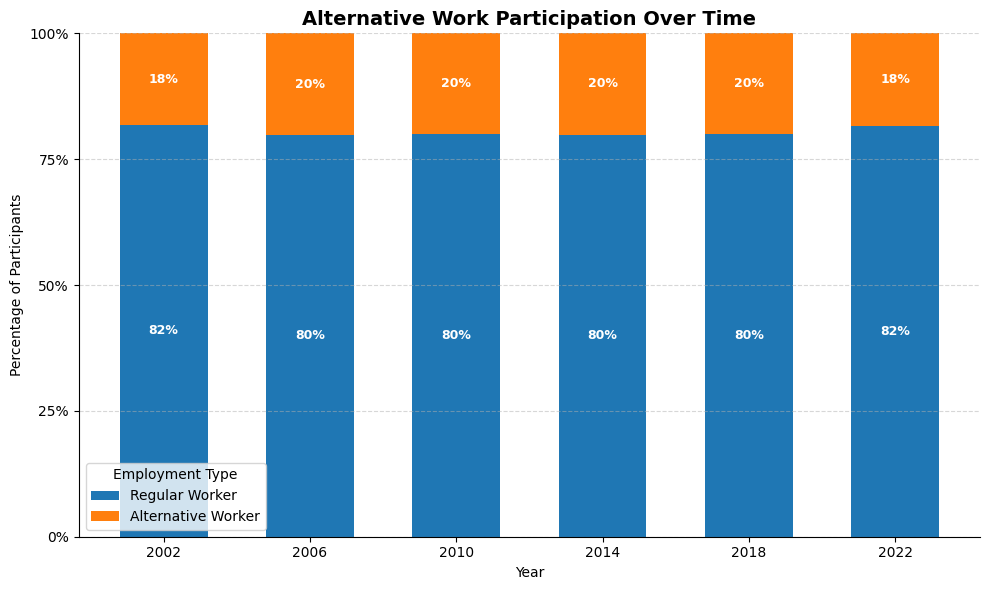

In [23]:
# calculate percentage of alternative vs regular worker yearly
grouped = merged.groupby(['year', 'Alt_worker_dummy']).size().reset_index(name='count')
grouped['percentage']= grouped.groupby('year')['count'].transform(lambda x: x/x.sum())
grouped['Worker_Type'] = grouped['Alt_worker_dummy'].map({1: 'Alternative Worker', 0: 'Regular Worker'})

# grouped.groupby('year') split data into separate groups for each year
# apply transformation function to count only
# x will be represented as the series of count values for each group (ie: 695, 155)


# Step 4: Pivot to wide format for stacking. This is easier because we get one row per year
# and seperate columns for each worker type
pivot = grouped.pivot(index='year', columns='Worker_Type', values='percentage').fillna(0)
pivot = pivot.sort_index()
pivot

colors = {'Regular Worker': '#1f77b4', 'Alternative Worker': '#ff7f0e'}
years = pivot.index.astype(str)
reg = pivot['Regular Worker']
alt = pivot['Alternative Worker']

fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(years, reg, label='Regular Worker', color=colors['Regular Worker'], width=0.6)
bar2 = ax.bar(years, alt, bottom=reg, label='Alternative Worker', color=colors['Alternative Worker'], width=0.6)

# chatgpt edit later
# Add text labels
for i in range(len(years)):
    ax.text(i, reg.iloc[i]/2, f"{reg.iloc[i]:.0%}", ha='center', va='center', color='white', weight='bold', fontsize=9)
    ax.text(i, reg.iloc[i] + alt.iloc[i]/2, f"{alt.iloc[i]:.0%}", ha='center', va='center', color='white', weight='bold', fontsize=9)

# Customize plot
ax.set_title("Alternative Work Participation Over Time", fontsize=14, weight='bold')
ax.set_xlabel("Year")
ax.set_ylabel("Percentage of Participants")
ax.set_ylim(0, 1)
ax.set_yticks(np.linspace(0, 1, 5))
ax.set_yticklabels([f"{int(p * 100)}%" for p in np.linspace(0, 1, 5)])
ax.legend(title="Employment Type")
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()


In [28]:
merged.to_pickle('merged.pk1')